In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    #total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0610/weights_KD_segformer_0610_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.3
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 7s 539ms/step - loss: 0.0850
Average validation loss: 0.6748589873313904
4/4 [==============================] - 7s 552ms/step - loss: 0.0850 - val_loss: 0.6749
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 9s 543ms/step - loss: 0.0582 - val_loss: 0.6749
Average validation loss: 0.5999740958213806
4/4 [==============================] - 9s 553ms/step - loss: 0.0582 - val_loss: 0.6374
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 11s 566ms/step - loss: 0.0446 - val_loss: 0.6374
Average validation loss: 0.5519981980323792
4/4 [==============================] - 11s 578ms/step - loss: 0.0446 - val_loss

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 737ms/step - loss: 4.0324e-05
Average validation loss: 0.1379115916788578
8/8 [==============================] - 6s 750ms/step - loss: 4.0324e-05 - val_loss: 0.1379
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 12s 771ms/step - loss: 3.9916e-05 - val_loss: 0.1379
Average validation loss: 2.5873863478409476e-06
8/8 [==============================] - 12s 781ms/step - loss: 3.9916e-05 - val_loss: 0.0690
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 18s 683ms/step - loss: 3.9365e-05 - val_loss: 0.0690
Average validation loss: 9.600225503447746e-09
8/8 [==============================] - 18s 693ms

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 8s 682ms/step - loss: 9.3214e-05
Average validation loss: 0.02492689061909914
12/12 [==============================] - 8s 691ms/step - loss: 9.3214e-05 - val_loss: 0.0249
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 17s 688ms/step - loss: 8.6318e-05 - val_loss: 0.0249
Average validation loss: 0.08505993239699168
12/12 [==============================] - 17s 697ms/step - loss: 8.6318e-05 - val_loss: 0.0550
Epoch 3/10
12/12 [==============================] - 25s 683ms/step - loss: 8.7353e-05 - val_loss: 0.0550
Average validation loss: 0.06721284620471124
12/12 [==============================] - 25s 692ms/step - loss: 8.7353e-05 - val_loss: 0.0591
Epoch 4/10
12/12 [==============================] - 33s 680ms/step - loss: 9.1561e-05 - val_loss: 0.0591
Average validation 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 11s 694ms/step - loss: 6.5487e-05
Average validation loss: 0.0272380038513802
16/16 [==============================] - 11s 704ms/step - loss: 6.5487e-05 - val_loss: 0.0272
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 721ms/step - loss: 6.1879e-05 - val_loss: 0.0272
Average validation loss: 0.04220485407859087
16/16 [==============================] - 23s 731ms/step - loss: 6.1879e-05 - val_loss: 0.0347
Epoch 3/10
16/16 [==============================] - 35s 745ms/step - loss: 6.0423e-05 - val_loss: 0.0347
Average validation loss: 0.061529118135922545
16/16 [==============================] - 35s 756ms/step - loss: 6.0423e-05 - val_loss: 0.0437
Epoch 4/10
16/16 [==============================] - 46s 703ms/step - loss: 5.8198e-05 - val_loss: 0.0437
Average validatio

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 718ms/step - loss: 2.7438e-05
Average validation loss: 0.042125891195610166
20/20 [==============================] - 15s 728ms/step - loss: 2.7438e-05 - val_loss: 0.0421
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 725ms/step - loss: 2.4470e-05 - val_loss: 0.0421
Average validation loss: 0.03122627860866487
20/20 [==============================] - 29s 734ms/step - loss: 2.4470e-05 - val_loss: 0.0367
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 44s 712ms/step - loss: 2.2380e-05 - val_loss: 0.0367
Average validation loss: 0.04460374338086694
20/20 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 710ms/step - loss: 5.1980e-05
Average validation loss: 0.025921377974251907
24/24 [==============================] - 17s 719ms/step - loss: 5.1980e-05 - val_loss: 0.0259
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 34s 691ms/step - loss: 4.0156e-05 - val_loss: 0.0259
Average validation loss: 0.045186594128608704
24/24 [==============================] - 34s 702ms/step - loss: 4.0156e-05 - val_loss: 0.0356
Epoch 3/10
24/24 [==============================] - 51s 699ms/step - loss: 3.2672e-05 - val_loss: 0.0356
Average validation loss: 0.03813104766110579
24/24 [==============================] - 51s 709ms/step - loss: 3.2672e-05 - val_loss: 0.0364
Epoch 4/10
24/24 [==============================] - 68s 693ms/step - loss: 2.9026e-05 - val_loss: 0.0364
Average validat

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 28s 706ms/step - loss: 9.4898e-05
Average validation loss: 0.07034466750919818
40/40 [==============================] - 29s 715ms/step - loss: 9.4898e-05 - val_loss: 0.0703
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 57s 700ms/step - loss: 8.4836e-05 - val_loss: 0.0703
Average validation loss: 0.053322764858603475
40/40 [==============================] - 57s 710ms/step - loss: 8.4836e-05 - val_loss: 0.0618
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 85s 704ms/step - loss: 7.2788e-05 - val_loss: 0.0618
Average validation loss: 0.030990511644631624
40/40 [==============================]

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 34s 709ms/step - loss: 5.3165e-05
Average validation loss: 0.021347350324504077
48/48 [==============================] - 35s 720ms/step - loss: 5.3165e-05 - val_loss: 0.0213
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 69s 715ms/step - loss: 3.6948e-05 - val_loss: 0.0213
Average validation loss: 0.02355897474141481
48/48 [==============================] - 69s 726ms/step - loss: 3.6948e-05 - val_loss: 0.0225
Epoch 3/10
48/48 [==============================] - 103s 709ms/step - loss: 3.0204e-05 - val_loss: 0.0225
Average validation loss: 0.01885347596059243
48/48 [==============================] - 104s 719ms/step - loss: 3.0204e-05 - val_loss: 0.0213
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/w

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 39s 699ms/step - loss: 7.1094e-05
Average validation loss: 0.02959501477224486
56/56 [==============================] - 40s 709ms/step - loss: 7.1094e-05 - val_loss: 0.0296
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 79s 703ms/step - loss: 4.7646e-05 - val_loss: 0.0296
Average validation loss: 0.02437717345310375
56/56 [==============================] - 80s 713ms/step - loss: 4.7646e-05 - val_loss: 0.0270
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 120s 715ms/step - loss: 4.0910e-05 - val_loss: 0.0270
Average validation loss: 0.027666766697490987
56/56 [==============================]

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 45s 705ms/step - loss: 3.4007e-05
Average validation loss: 0.026049499378132168
64/64 [==============================] - 46s 715ms/step - loss: 3.4007e-05 - val_loss: 0.0260
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 91s 706ms/step - loss: 2.3417e-05 - val_loss: 0.0260
Average validation loss: 0.01846778445178643
64/64 [==============================] - 92s 716ms/step - loss: 2.3417e-05 - val_loss: 0.0223
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 137s 707ms/step - loss: 1.8095e-05 - val_loss: 0.0223
Average validation loss: 0.01768393854581518
64/64 [==============================]

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 50s 700ms/step - loss: 3.1456e-05
Average validation loss: 0.04088209429755807
72/72 [==============================] - 51s 710ms/step - loss: 3.1456e-05 - val_loss: 0.0409
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 103s 716ms/step - loss: 2.1551e-05 - val_loss: 0.0409
Average validation loss: 0.015738935960042808
72/72 [==============================] - 103s 726ms/step - loss: 2.1551e-05 - val_loss: 0.0283
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 154s 703ms/step - loss: 1.6309e-05 - val_loss: 0.0283
Average validation loss: 0.012233972394218048
72/72 [============================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 57s 707ms/step - loss: 2.7213e-05
Average validation loss: 0.03321476057171822
80/80 [==============================] - 57s 718ms/step - loss: 2.7213e-05 - val_loss: 0.0332
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 114s 702ms/step - loss: 1.9182e-05 - val_loss: 0.0332
Average validation loss: 0.04127288311719894
80/80 [==============================] - 114s 712ms/step - loss: 1.9182e-05 - val_loss: 0.0372
Epoch 3/10
80/80 [==============================] - 170s 700ms/step - loss: 1.5166e-05 - val_loss: 0.0372
Average validation loss: 0.0168284562882036
80/80 [==============================] - 171s 710ms/step - loss: 1.5166e-05 - val_loss: 0.0304
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 67s 700ms/step - loss: 6.3814e-05
Average validation loss: 0.03870605182116075
96/96 [==============================] - 68s 710ms/step - loss: 6.3814e-05 - val_loss: 0.0387
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 136s 701ms/step - loss: 4.2488e-05 - val_loss: 0.0387
Average validation loss: 0.033680194561990597
96/96 [==============================] - 136s 711ms/step - loss: 4.2488e-05 - val_loss: 0.0362
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 204s 704ms/step - loss: 3.1184e-05 - val_loss: 0.0362
Average validation loss: 0.034231849965484194
96/96 [==========================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 84s 700ms/step - loss: 2.8826e-05
Average validation loss: 0.022720709013325784
120/120 [==============================] - 85s 710ms/step - loss: 2.8826e-05 - val_loss: 0.0227
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 171s 711ms/step - loss: 2.1677e-05 - val_loss: 0.0227
Average validation loss: 0.014531349759393682
120/120 [==============================] - 172s 721ms/step - loss: 2.1677e-05 - val_loss: 0.0186
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 257s 707ms/step - loss: 1.6778e-05 - val_loss: 0.0186
Average validation loss: 0.018397906438137095
120/120 [=============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 101s 700ms/step - loss: 1.9970e-05
Average validation loss: 0.023084375886052538
144/144 [==============================] - 102s 710ms/step - loss: 1.9970e-05 - val_loss: 0.0231
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 203s 702ms/step - loss: 1.6113e-05 - val_loss: 0.0231
Average validation loss: 0.017661019066710852
144/144 [==============================] - 205s 713ms/step - loss: 1.6113e-05 - val_loss: 0.0204
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 306s 700ms/step - loss: 1.3009e-05 - val_loss: 0.0204
Average validation loss: 0.026789396652020514
144/144 [===========

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 112s 699ms/step - loss: 1.0950e-05
Average validation loss: 0.015198617137502878
160/160 [==============================] - 113s 709ms/step - loss: 1.0950e-05 - val_loss: 0.0152
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 225s 699ms/step - loss: 8.6045e-06 - val_loss: 0.0152
Average validation loss: 0.02286741126299603
160/160 [==============================] - 227s 709ms/step - loss: 8.6045e-06 - val_loss: 0.0190
Epoch 3/10
160/160 [==============================] - 339s 704ms/step - loss: 7.2336e-06 - val_loss: 0.0190
Average validation loss: 0.024497576338194448
160/160 [==============================] - 341s 714ms/step - loss: 7.2336e-06 - val_loss: 0.0209
Epoch 4/10
160/160 [==============================] - 453s 702ms/step - loss: 6.3359e-06 - val_loss: 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 142s 712ms/step - loss: 5.0883e-05
Average validation loss: 0.03326366359367967
200/200 [==============================] - 144s 722ms/step - loss: 5.0883e-05 - val_loss: 0.0333
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 285s 700ms/step - loss: 3.4062e-05 - val_loss: 0.0333
Average validation loss: 0.03075996064086212
200/200 [==============================] - 286s 710ms/step - loss: 3.4062e-05 - val_loss: 0.0320
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 427s 703ms/step - loss: 2.6300e-05 - val_loss: 0.0320
Average validation loss: 0.01988873911162955
200/200 [==============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 3:09 - loss: 1.0228e-05

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 168s 701ms/step - loss: 2.2363e-05
Average validation loss: 0.03401061548150513
240/240 [==============================] - 171s 711ms/step - loss: 2.2363e-05 - val_loss: 0.0340
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 339s 703ms/step - loss: 1.4909e-05 - val_loss: 0.0340
Average validation loss: 0.021731866259263672
240/240 [==============================] - 342s 713ms/step - loss: 1.4909e-05 - val_loss: 0.0279
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_30\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 510s 700ms/step - loss: 1.1459e-05 - val_loss: 0.0279
Average validation loss: 0.022116310185325953
240/240 [============

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.12123083479883234, 0.0607103349999476, 0.08122111116451265, 0.04718160820625144, 0.030489480397460286, 0.02391264140033551, 0.028126305509475057, 0.021981436522619337, 0.02581697753557819, 0.020712143809669216, 0.015355550060068912, 0.01716618039849709, 0.02234310011095052, 0.015589564539783168, 0.01596960321432966, 0.01874145495174355, 0.021729148755234292, 0.018801744535258572]
std_val_losses =  [0.18531359553897822, 0.055918149048172994, 0.054767651611973577, 0.018927465906682938, 0.015519139056662832, 0.020147010781565125, 0.01442767894785283, 0.007562718538374677, 0.014853027223898824, 0.02120488776059871, 0.006060931051487695, 0.009691477333480292, 0.012575982915050457, 0.00514295600712464, 0.005277522185281065, 0.013711479667600645, 0.01485334717179918, 0.013100586323129583]


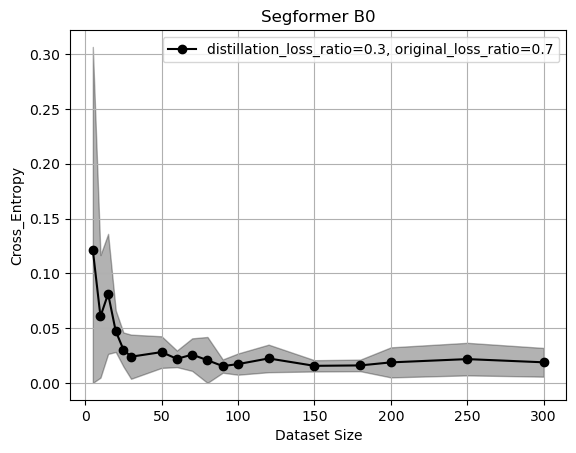

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0610')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.png"))

plt.show()